**1.Library Imports and Setup**

imports all necessary libraries and sets up the environment for the sentiment analysis task:


**Basic libraries:** numpy, pandas, matplotlib, seaborn for data manipulation and visualization


**NLP libraries:** NLTK for natural language processing tasks (tokenization, stopwords, stemming)


**PyTorch libraries:** For building and training deep learning models


**Evaluation libraries:** For model evaluation metrics (accuracy, precision, recall, F1)


also downloads necessary NLTK data (punkt, stopwords, wordnet), sets random seeds for reproducibility (42), and checks for CUDA availability to determine whether to use GPU or CPU for training.



In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import time
from collections import Counter
from tqdm.notebook import tqdm

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


[nltk_data] Downloading package punkt to /Users/ahadm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ahadm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**2.Data Loading and Preparation**

This cell loads the IMDb Movie Reviews dataset which is one of the datasets specified in the exam requirements. The code:



1.   Defines a function to read text files from folders
2.   Loads positive and negative reviews from both training and testing sets

3.   Creates datasets with appropriate labels (1 for positive, 0 for negative)
4.   Shuffles the data to ensure random distribution
5.   Converts data to NumPy arrays for easier manipulation
6.   Displays information about the dataset









**The output shows:**




*  25,000 training reviews (12,500 positive, 12,500 negative)
*   25,000 testing reviews (12,500 positive, 12,500 negative)











In [ ]:
# Define data path
data_path = '/Users/ahadm/Downloads/aclImdb'

# Function to read text files from folders
def read_text_files(path):
    reviews = []
    for filename in tqdm(os.listdir(path)):
        if filename.endswith('.txt'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                reviews.append(file.read())
    return reviews

# Read training data
print("Reading training data...")
train_pos_path = os.path.join(data_path, 'train', 'pos')
train_neg_path = os.path.join(data_path, 'train', 'neg')

train_pos_reviews = read_text_files(train_pos_path)
train_neg_reviews = read_text_files(train_neg_path)

# Read testing data
print("Reading testing data...")
test_pos_path = os.path.join(data_path, 'test', 'pos')
test_neg_path = os.path.join(data_path, 'test', 'neg')

test_pos_reviews = read_text_files(test_pos_path)
test_neg_reviews = read_text_files(test_neg_path)

# Create datasets with labels
train_reviews = train_pos_reviews + train_neg_reviews
train_labels = [1] * len(train_pos_reviews) + [0] * len(train_neg_reviews)

test_reviews = test_pos_reviews + test_neg_reviews
test_labels = [1] * len(test_pos_reviews) + [0] * len(test_neg_reviews)

# Shuffle the data
train_data = list(zip(train_reviews, train_labels))
test_data = list(zip(test_reviews, test_labels))

np.random.shuffle(train_data)
np.random.shuffle(test_data)

train_reviews, train_labels = zip(*train_data)
test_reviews, test_labels = zip(*test_data)

# Convert to NumPy arrays
train_reviews = np.array(train_reviews)
train_labels = np.array(train_labels)
test_reviews = np.array(test_reviews)
test_labels = np.array(test_labels)

# Display information about the data
print(f"Number of training reviews: {len(train_reviews)}")
print(f"Number of testing reviews: {len(test_reviews)}")
print(f"Label distribution in training set: Positive={np.sum(train_labels)}, Negative={len(train_labels) - np.sum(train_labels)}")
print(f"Label distribution in testing set: Positive={np.sum(test_labels)}, Negative={len(test_labels) - np.sum(test_labels)}")

Reading training data...


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Reading testing data...


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Number of training reviews: 25000
Number of testing reviews: 25000
Label distribution in training set: Positive=12500, Negative=12500
Label distribution in testing set: Positive=12500, Negative=12500


 **Sample Review Display**

 displays sample positive and negative reviews to provide insight into the data.

In [ ]:
# Display samples of positive and negative reviews
print("Sample positive review:")
print(train_reviews[np.where(train_labels == 1)[0][0]][:500] + "...")
print("\nSample negative review:")
print(train_reviews[np.where(train_labels == 0)[0][0]][:500] + "...")

Sample positive review:
Great little thriller. I was expecting some type of silly horror movie but what I got was tight short thriller that waste none of our time. Mostof these movies we have to get into the back characters stories so we will either feel sympathy for them or hatred when people start getting killed. o such foolishness here. Yes you see a few characters but they really only interact with the principals. Such as the husband wife at the motel whose room was canceled. We saw them so we could just how effici...

Sample negative review:
Nothing could have saved this movie, not even Superman.<br /><br />Ten years ago the special effects would have been amazing. Better directing might have gotten some more feeling and better performances out of the actors. But nothing but feeding the script to a dragon could have fixed it. Plot holes, bad lines, terrible pacing, endless replaying of the same shots of a CGI dragon stomping through hallways... ugh.<br /><br />Avoid this one at al

**3.Text Preprocessing**

I implements comprehensive text preprocessing steps:


1.   **Text cleaning function**: Converts to lowercase, removes HTML tags, URLs, punctuation, numbers, and extra spaces
2.   **Tokenization and stopword removal**: Splits text into tokens and removes common English stopwords
3.   **Application to datasets:** Applies these preprocessing steps to both training and testing data






In [ ]:
# Function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Function for tokenization and stopword removal
def tokenize_and_remove_stopwords(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Apply cleaning and tokenization to all reviews
print("Cleaning and tokenizing training data...")
train_cleaned = [clean_text(review) for review in tqdm(train_reviews)]
train_tokenized = [tokenize_and_remove_stopwords(review) for review in tqdm(train_cleaned)]

print("Cleaning and tokenizing testing data...")
test_cleaned = [clean_text(review) for review in tqdm(test_reviews)]
test_tokenized = [tokenize_and_remove_stopwords(review) for review in tqdm(test_cleaned)]

Cleaning and tokenizing training data...


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Cleaning and tokenizing testing data...


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

**4.Word2Vec Embedding**

trains a Word2Vec model on the preprocessed text data:


1.   Sets embedding parameters (dimension=100, window_size=5, min_count=5)
2.   Trains the Word2Vec model on the training data


3.   Saves the model for later use

2.   Displays vocabulary size (30,607 words)


5.   Shows words similar to "good" to demonstrate the semantic relationships captured










In [ ]:
# Train Word2Vec model
embedding_dim = 100  # Dimensions of word vectors
window_size = 5      # Window size for surrounding words
min_count = 5        # Minimum word frequency threshold

print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=train_tokenized,
                     vector_size=embedding_dim,
                     window=window_size,
                     min_count=min_count,
                     workers=4)

# Save the model for later use
w2v_model.save("imdb_word2vec.model")

# Display vocabulary size
vocab_size = len(w2v_model.wv.index_to_key)
print(f"Vocabulary size after Word2Vec training: {vocab_size}")

# Display some similar words
print("\nWords similar to 'good':")
try:
    similar_words = w2v_model.wv.most_similar('good', topn=5)
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
except KeyError:
    print("The word 'good' is not in the vocabulary.")

Training Word2Vec model...
Vocabulary size after Word2Vec training: 30607

Words similar to 'good':
decent: 0.7497
great: 0.7000
bad: 0.6815
nice: 0.6344
fine: 0.6328


**5.Sequence Processing and Embedding Matrix**

I prepares the text data for deep learning models:


1.   Creates a word-to-index dictionary from the Word2Vec vocabulary
2.   Adds special tokens for padding and unknown words


3.   Converts tokenized reviews to numerical sequences
2.   Implements padding to ensure uniform sequence length (200 tokens)


5.   Creates an embedding matrix from the Word2Vec model
2.   Displays the shapes of the embedding matrix and padded data














In [ ]:
# Create word dictionary
word_index = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}

# Add tokens for unknown words and padding
word_index['<PAD>'] = 0
word_index['<UNK>'] = len(word_index)

# Set maximum review length
max_sequence_length = 200

# Function to convert reviews to numerical sequences
def texts_to_sequences(tokenized_texts, word_index):
    sequences = []
    for text in tokenized_texts:
        seq = [word_index.get(word, word_index['<UNK>']) for word in text]
        sequences.append(seq)
    return sequences

# Convert reviews to numerical sequences
train_sequences = texts_to_sequences(train_tokenized, word_index)
test_sequences = texts_to_sequences(test_tokenized, word_index)

# Pad sequences
def pad_sequences(sequences, maxlen, padding='post', truncating='post'):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            # Truncate
            if truncating == 'post':
                seq = seq[:maxlen]
            else:  # 'pre'
                seq = seq[-maxlen:]
        else:
            # Pad
            pad_length = maxlen - len(seq)
            if padding == 'post':
                seq = seq + [0] * pad_length
            else:  # 'pre'
                seq = [0] * pad_length + seq
        padded_sequences.append(seq)
    return np.array(padded_sequences)

train_padded = pad_sequences(train_sequences, max_sequence_length)
test_padded = pad_sequences(test_sequences, max_sequence_length)

# Create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Training data shape after padding: {train_padded.shape}")
print(f"Testing data shape after padding: {test_padded.shape}")

Embedding matrix shape: (30610, 100)
Training data shape after padding: (25000, 200)
Testing data shape after padding: (25000, 200)


 **6.Data Splitting and PyTorch Dataset Creation**

In This cell I:


1.   Splits the training data into training (90%) and validation (10%) sets
2.   Converts the data to PyTorch tensors



3.   Creates DataLoader objects for batch processing during training
4.   Displays the final shapes of the training, validation, and testing data









In [ ]:
# Split training data into training and validation sets
val_split = 0.1
indices = np.arange(train_padded.shape[0])
np.random.shuffle(indices)
train_indices = indices[int(val_split * indices.shape[0]):]
val_indices = indices[:int(val_split * indices.shape[0])]

x_train = train_padded[train_indices]
y_train = train_labels[train_indices]
x_val = train_padded[val_indices]
y_val = train_labels[val_indices]
x_test = test_padded
y_test = test_labels

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader objects
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Final training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Testing data shape: {x_test.shape}")

Final training data shape: (22500, 200)
Validation data shape: (2500, 200)
Testing data shape: (25000, 200)


**7.Training and Evaluation Functions**

 I define two important functions:


1.   **train_model:** Handles the training process with:


  *   Early stopping to prevent overfitting
  *   Tracking of metrics (loss, accuracy) for both training and validation sets


  *   Optimization and backpropagation
  *   Model state saving for best performance




2.   **evaluate_model:** Performs comprehensive model evaluation with:


*   Calculation of accuracy, precision, recall, and F1 score

*   Confusion matrix visualization
*   ROC curve plotting


*   Detailed classification report


3.   plot_training_history: Visualizes training and validation metrics over epochs



















In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate epoch metrics
        train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Evaluation function
def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Print results
    print(f"\n===== {model_name} Model Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Model')
    plt.legend(loc="lower right")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracies'])
    plt.plot(history['val_accuracies'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_losses'])
    plt.plot(history['val_losses'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

 **8.CNN Model Implementation and Training**

I:


1.   Define the CNN model architecture with:


*   Embedding layer
*   Three convolutional layers with ReLU activation and max pooling
*   Fully connected layers with dropout for regularization
*   Sigmoid activation for binary classification




2.   Trains the model using:


*   Binary cross-entropy loss
*   Adam optimizer
*   Early stopping for regularization





3.   Evaluates the model performance:


*   Accuracy: 85.73%

*   Precision: 83.01%
*   Recall: 89.86%


*   F1 Score: 86.30%




















Training CNN model...
CNNModel(
  (embedding): Embedding(30610, 100)
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.4128, Train Acc: 0.8099 - Val Loss: 0.3540, Val Acc: 0.8440


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.3360, Train Acc: 0.8595 - Val Loss: 0.3366, Val Acc: 0.8580


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.3075, Train Acc: 0.8717 - Val Loss: 0.3267, Val Acc: 0.8584


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.2740, Train Acc: 0.8905 - Val Loss: 0.3205, Val Acc: 0.8692


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.2347, Train Acc: 0.9060 - Val Loss: 0.3421, Val Acc: 0.8604


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.1930, Train Acc: 0.9247 - Val Loss: 0.3418, Val Acc: 0.8616


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.1483, Train Acc: 0.9449 - Val Loss: 0.4394, Val Acc: 0.8564
Early stopping at epoch 7

===== CNN Model Evaluation =====
Accuracy: 0.8573
Precision: 0.8301
Recall: 0.8986
F1 Score: 0.8630


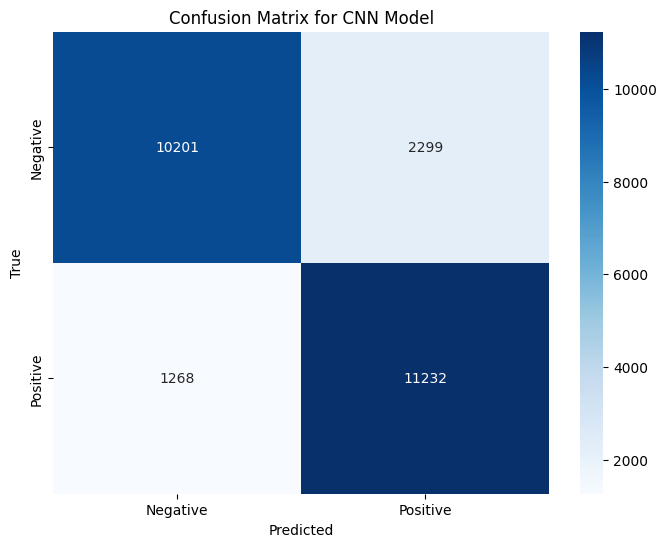

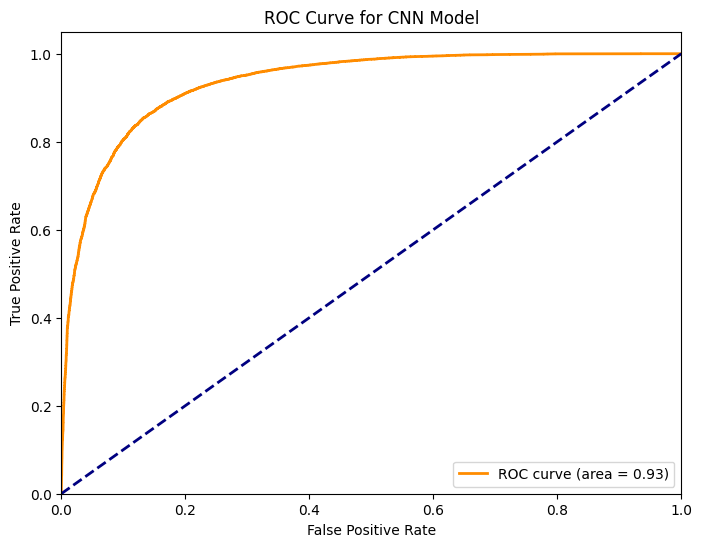


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85     12500
    Positive       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



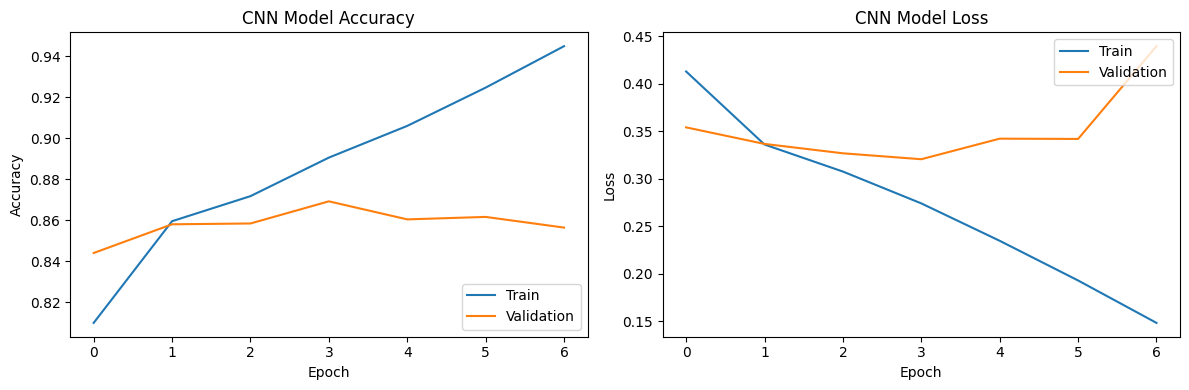

In [ ]:
# Define CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_seq_length):
        super(CNNModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Initialize with pre-trained embeddings
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # Convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate the size after convolutions and pooling
        self.flat_size = 32 * (max_seq_length // 8)  # After 3 pooling layers with kernel_size=2

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # Transpose for convolution (batch_size, embedding_dim, seq_length)
        x = x.transpose(1, 2)

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

# Create and train CNN model
print("Training CNN model...")
vocab_size = len(word_index) + 1
cnn_model = CNNModel(vocab_size, embedding_dim, embedding_matrix, max_sequence_length).to(device)

# Print model summary
print(cnn_model)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the model
cnn_model, cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

# Save the model
torch.save(cnn_model.state_dict(), 'cnn_model.pth')

# Evaluate the model
cnn_results = evaluate_model(cnn_model, test_loader, "CNN")

# Plot training history
plot_training_history(cnn_history, "CNN")

**9.LeNet Model Implementation and Training**

In This cell I:


1.   Define the LeNet model architecture with:


*   Embedding layer

*   Two 2D convolutional layers with max pooling
*   Three fully connected layers with dropout


*   Sigmoid activation for binary classification


2.   Trains and evaluates the model:


*   Accuracy: 80.43%

*   Precision: 82.10%
*   Recall: 77.82%


*   F1 Score: 79.90%













Training LeNet model...
LeNetModel(
  (embedding): Embedding(30610, 100)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=17664, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.5067, Train Acc: 0.7496 - Val Loss: 0.4348, Val Acc: 0.8040


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.4122, Train Acc: 0.8162 - Val Loss: 0.4301, Val Acc: 0.7988


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.3819, Train Acc: 0.8315 - Val Loss: 0.4144, Val Acc: 0.8104


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.3545, Train Acc: 0.8448 - Val Loss: 0.4306, Val Acc: 0.8100


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.3233, Train Acc: 0.8593 - Val Loss: 0.4287, Val Acc: 0.8092


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.2828, Train Acc: 0.8767 - Val Loss: 0.4549, Val Acc: 0.8024
Early stopping at epoch 6

===== LeNet Model Evaluation =====
Accuracy: 0.8043
Precision: 0.8210
Recall: 0.7782
F1 Score: 0.7990


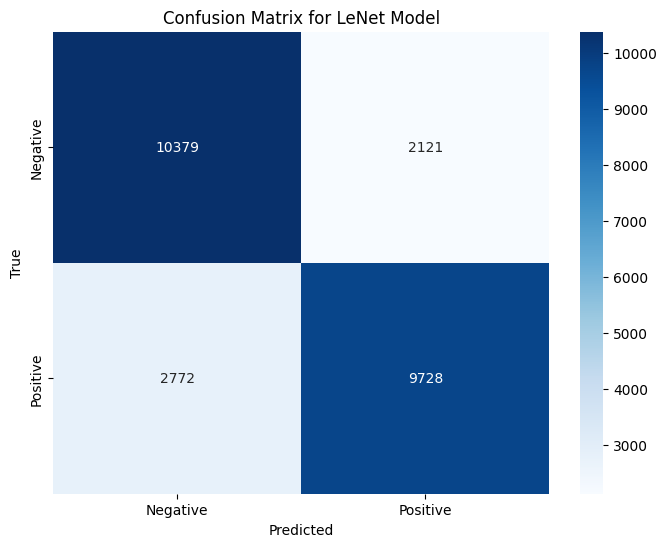

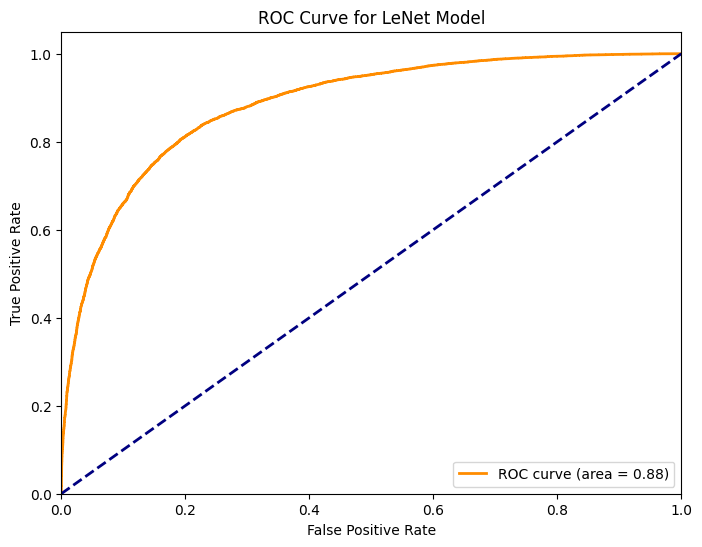


Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81     12500
    Positive       0.82      0.78      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



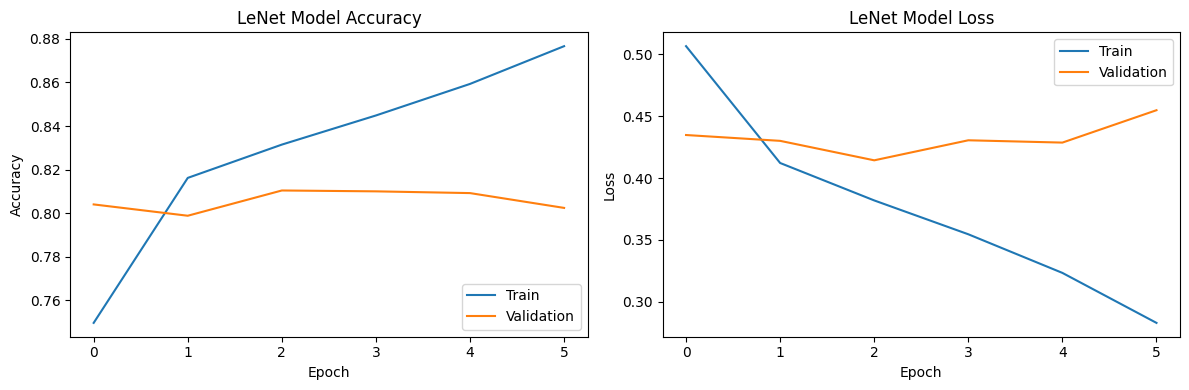

In [ ]:
# Define LeNet model
class LeNetModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_seq_length):
        super(LeNetModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Initialize with pre-trained embeddings
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # Reshape parameters
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Calculate the size after convolutions and pooling
        # After first pooling: (max_seq_length // 2, embedding_dim // 2)
        # After second pooling: ((max_seq_length // 2 - 4) // 2, (embedding_dim // 2 - 4) // 2)
        conv_output_height = (max_seq_length // 2 - 4) // 2
        conv_output_width = (embedding_dim // 2 - 4) // 2
        self.flat_size = 16 * conv_output_height * conv_output_width

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # Reshape for 2D convolution
        x = x.unsqueeze(1)  # (batch_size, 1, seq_length, embedding_dim)

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

# Create and train LeNet model
print("Training LeNet model...")
lenet_model = LeNetModel(vocab_size, embedding_dim, embedding_matrix, max_sequence_length).to(device)

# Print model summary
print(lenet_model)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

# Train the model
lenet_model, lenet_history = train_model(lenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

# Save the model
torch.save(lenet_model.state_dict(), 'lenet_model.pth')

# Evaluate the model
lenet_results = evaluate_model(lenet_model, test_loader, "LeNet")

# Plot training history
plot_training_history(lenet_history, "LeNet")

**10.RBM Model Implementation and Training**

In This cell I:


1.  Implement a Restricted Boltzmann Machine (RBM) with:


*   Visible and hidden layers

*   Contrastive divergence learning
*   Energy-based model formulation






2.   Create a classifier using RBM features:


*   Extracts features from the trained RBM
*   Feeds them into a classifier network


3.   Trains and evaluates the model:


*   Accuracy: 50.00%


*   Precision: 50.00%

*   Recall: 100.00%


*  F1 Score: 66.67%


















Training RBM model...


RBM Epoch 1/5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1/5, Loss: 7.9358


RBM Epoch 2/5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2/5, Loss: 7.0615


RBM Epoch 3/5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3/5, Loss: 7.0559


RBM Epoch 4/5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4/5, Loss: 7.0521


RBM Epoch 5/5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5/5, Loss: 7.0461
RBMClassifier(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.6938, Train Acc: 0.4987 - Val Loss: 0.6931, Val Acc: 0.4956


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.6935, Train Acc: 0.4974 - Val Loss: 0.6931, Val Acc: 0.5140


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.6932, Train Acc: 0.5038 - Val Loss: 0.6932, Val Acc: 0.4976


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.6932, Train Acc: 0.5012 - Val Loss: 0.6932, Val Acc: 0.4976
Early stopping at epoch 4

===== RBM Model Evaluation =====
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667


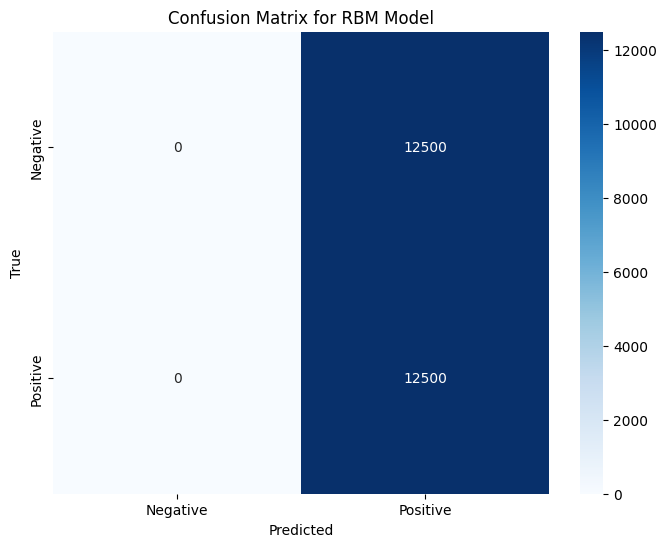

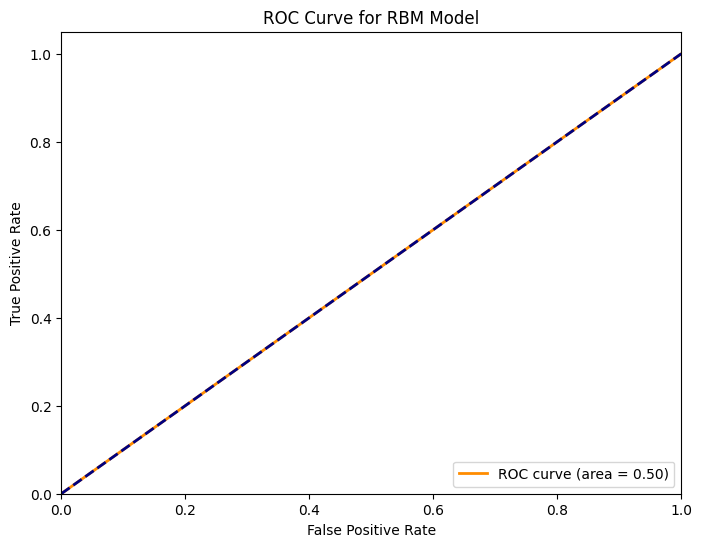


Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12500
    Positive       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


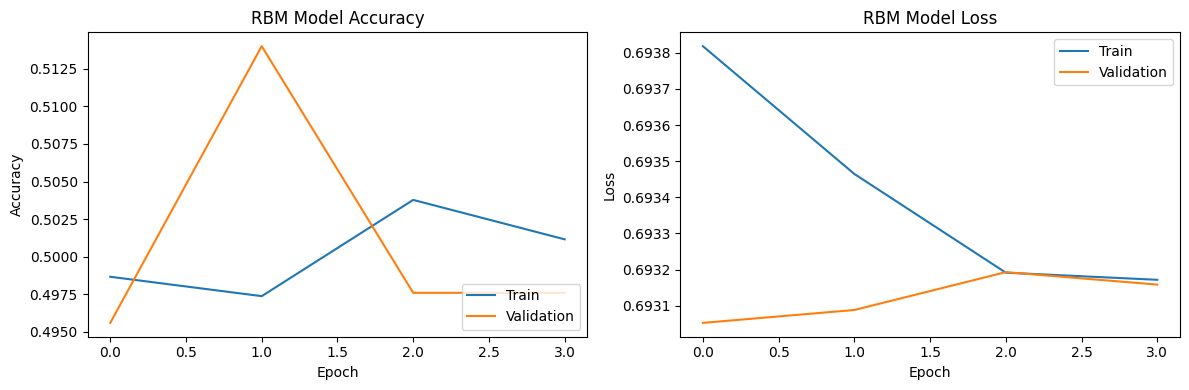

In [ ]:
# Define RBM model
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # Initialize weights and biases
        self.weights = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.visible_bias = nn.Parameter(torch.zeros(n_visible))
        self.hidden_bias = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, visible):
        # Calculate hidden unit probabilities
        hidden_prob = torch.sigmoid(F.linear(visible, self.weights.t(), self.hidden_bias))
        # Sample from Bernoulli distribution
        hidden_sample = torch.bernoulli(hidden_prob)
        return hidden_prob, hidden_sample

    def sample_visible(self, hidden):
        # Calculate visible unit probabilities
        visible_prob = torch.sigmoid(F.linear(hidden, self.weights, self.visible_bias))
        # Sample from Bernoulli distribution
        visible_sample = torch.bernoulli(visible_prob)
        return visible_prob, visible_sample

    def forward(self, visible):
        # Forward pass for feature extraction
        hidden_prob, _ = self.sample_hidden(visible)
        return hidden_prob

    def free_energy(self, visible):
        # Calculate free energy
        vbias_term = torch.matmul(visible, self.visible_bias)
        wx_b = F.linear(visible, self.weights.t(), self.hidden_bias)
        hidden_term = torch.sum(F.softplus(wx_b), dim=1)
        return -hidden_term - vbias_term

# Function to train RBM
def train_rbm(rbm, train_loader, num_epochs=5, learning_rate=0.01):
    optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"RBM Epoch {epoch+1}/{num_epochs}")):
            data = data.view(data.size(0), -1).float() / torch.max(data.float())  # Flatten and normalize

            # Positive phase
            positive_hidden_prob, positive_hidden_sample = rbm.sample_hidden(data)

            # Negative phase
            negative_visible_prob, negative_visible_sample = rbm.sample_visible(positive_hidden_sample)
            negative_hidden_prob, _ = rbm.sample_hidden(negative_visible_prob)

            # Compute gradients using contrastive divergence
            positive_associations = torch.matmul(data.t(), positive_hidden_prob)
            negative_associations = torch.matmul(negative_visible_prob.t(), negative_hidden_prob)

            # Update weights and biases
            optimizer.zero_grad()

            # Manually compute gradients
            rbm.weights.grad = -(positive_associations - negative_associations) / data.size(0)
            rbm.visible_bias.grad = -torch.mean(data - negative_visible_prob, dim=0)
            rbm.hidden_bias.grad = -torch.mean(positive_hidden_prob - negative_hidden_prob, dim=0)

            optimizer.step()

            # Compute reconstruction error
            batch_loss = torch.mean(torch.sum((data - negative_visible_prob)**2, dim=1))
            epoch_loss += batch_loss.item()

        # Print epoch loss
        epoch_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return rbm

# Prepare data for RBM
def prepare_data_for_rbm(data_loader):
    all_data = []
    all_labels = []

    for data, labels in data_loader:
        # Flatten and normalize
        flattened_data = data.view(data.size(0), -1).float() / torch.max(data.float())
        all_data.append(flattened_data)
        all_labels.append(labels)

    return torch.cat(all_data), torch.cat(all_labels)

# Create RBM dataset and loader
batch_size_rbm = 100
train_data_rbm, train_labels_rbm = prepare_data_for_rbm(train_loader)
val_data_rbm, val_labels_rbm = prepare_data_for_rbm(val_loader)
test_data_rbm, test_labels_rbm = prepare_data_for_rbm(test_loader)

train_dataset_rbm = TensorDataset(train_data_rbm, train_labels_rbm)
train_loader_rbm = DataLoader(train_dataset_rbm, batch_size=batch_size_rbm, shuffle=True)

# Train RBM model
print("Training RBM model...")
n_visible = train_data_rbm.shape[1]
n_hidden = 256  # Number of hidden units

rbm_model = RBM(n_visible, n_hidden).to(device)
rbm_model = train_rbm(rbm_model, train_loader_rbm, num_epochs=5, learning_rate=0.01)

# Transform data using RBM
with torch.no_grad():
    train_features = rbm_model(train_data_rbm)
    val_features = rbm_model(val_data_rbm)
    test_features = rbm_model(test_data_rbm)

# Create classifier using RBM features
class RBMClassifier(nn.Module):
    def __init__(self, input_dim):
        super(RBMClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Create datasets for classifier
train_dataset_rbm_clf = TensorDataset(train_features, train_labels_rbm)
val_dataset_rbm_clf = TensorDataset(val_features, val_labels_rbm)
test_dataset_rbm_clf = TensorDataset(test_features, test_labels_rbm)

train_loader_rbm_clf = DataLoader(train_dataset_rbm_clf, batch_size=batch_size, shuffle=True)
val_loader_rbm_clf = DataLoader(val_dataset_rbm_clf, batch_size=batch_size)
test_loader_rbm_clf = DataLoader(test_dataset_rbm_clf, batch_size=batch_size)

# Train classifier
rbm_classifier = RBMClassifier(n_hidden).to(device)
print(rbm_classifier)

criterion = nn.BCELoss()
optimizer = optim.Adam(rbm_classifier.parameters(), lr=0.001)

rbm_classifier, rbm_history = train_model(rbm_classifier, train_loader_rbm_clf, val_loader_rbm_clf, criterion, optimizer, num_epochs=10, patience=3)

# Save the model
torch.save(rbm_classifier.state_dict(), 'rbm_model.pth')

# Evaluate the model
rbm_results = evaluate_model(rbm_classifier, test_loader_rbm_clf, "RBM")

# Plot training history
plot_training_history(rbm_history, "RBM")

**11.DBN Model Implementation and Training**

In This cell I:


1.   Implement a Deep Belief Network (DBN) by:


*   Stacking multiple RBMs


*   Pre-training each layer greedily
*   Fine-tuning with backpropagation






2.   Creates a classifier using DBN features:


*   Extracts features from the trained DBN
*   Feeds them into a classifier network


3.   Trains and evaluates the model:



*   Accuracy: 50%


*   Precision: 0%

*   Recall: 0%



*   F1 Score: 0%














Training DBN model...
Training RBM layer 1/3...


RBM Epoch 1/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1/3, Loss: 7.6338


RBM Epoch 2/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2/3, Loss: 7.2335


RBM Epoch 3/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3/3, Loss: 7.2315
Training RBM layer 2/3...


RBM Epoch 1/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1/3, Loss: 2.7145


RBM Epoch 2/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2/3, Loss: 2.0142


RBM Epoch 3/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3/3, Loss: 2.0164
Training RBM layer 3/3...


RBM Epoch 1/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1/3, Loss: 0.7070


RBM Epoch 2/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.0584


RBM Epoch 3/3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.0584
DBNClassifier(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.6939, Train Acc: 0.5021 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.6933, Train Acc: 0.5022 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.6932, Train Acc: 0.5022 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.6932, Train Acc: 0.5013 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.6932, Train Acc: 0.5002 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.6932, Train Acc: 0.4986 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.6932, Train Acc: 0.4975 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.6932, Train Acc: 0.4998 - Val Loss: 0.6932, Val Acc: 0.4976


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.6932, Train Acc: 0.4967 - Val Loss: 0.6931, Val Acc: 0.5024


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.6932, Train Acc: 0.4965 - Val Loss: 0.6931, Val Acc: 0.5024
Early stopping at epoch 10

===== DBN Model Evaluation =====
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


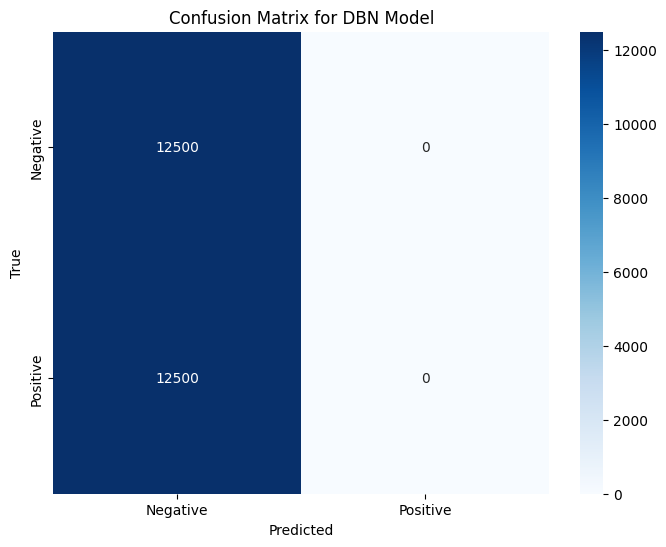

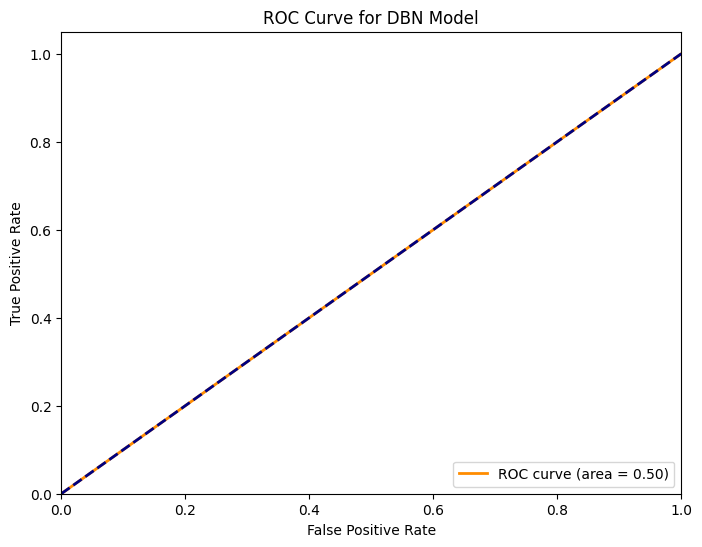

/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ahadm/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12500
    Positive       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



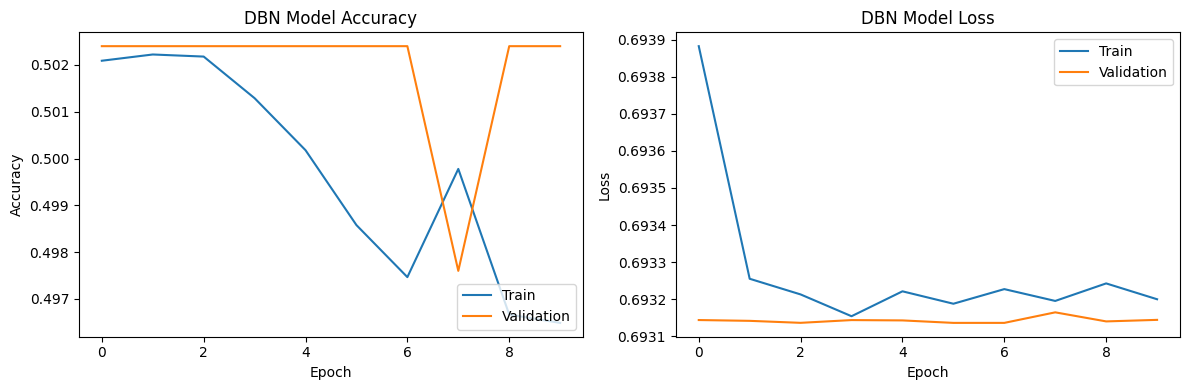

In [ ]:
# Define DBN model
class DBN(nn.Module):
    def __init__(self, layer_sizes):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList()

        # Create RBM layers
        for i in range(len(layer_sizes) - 1):
            self.rbm_layers.append(RBM(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        # Forward pass through all RBM layers
        for rbm in self.rbm_layers:
            x = rbm(x)
        return x

# Function to pretrain DBN
def pretrain_dbn(dbn, train_loader, num_epochs=3, learning_rate=0.01):
    # Train each RBM layer
    input_data = None

    for i, rbm in enumerate(dbn.rbm_layers):
        print(f"Training RBM layer {i+1}/{len(dbn.rbm_layers)}...")

        # For the first layer, use original data
        if i == 0:
            # Create a loader for this layer
            layer_loader = train_loader
        else:
            # Transform data using previous layers
            transformed_data = []
            transformed_labels = []

            with torch.no_grad():
                for data, labels in train_loader:
                    data = data.view(data.size(0), -1).float() / torch.max(data.float())
                    for j in range(i):
                        data = dbn.rbm_layers[j](data)
                    transformed_data.append(data)
                    transformed_labels.append(labels)

            # Create dataset and loader for this layer
            transformed_data = torch.cat(transformed_data)
            transformed_labels = torch.cat(transformed_labels)
            layer_dataset = TensorDataset(transformed_data, transformed_labels)
            layer_loader = DataLoader(layer_dataset, batch_size=batch_size_rbm, shuffle=True)

        # Train this RBM layer
        train_rbm(rbm, layer_loader, num_epochs=num_epochs, learning_rate=learning_rate)

    return dbn

# Define layer sizes for DBN
hidden_layers_sizes = [512, 256, 128]  # Hidden layer sizes
layer_sizes = [n_visible] + hidden_layers_sizes

# Create and pretrain DBN model
print("Training DBN model...")
dbn_model = DBN(layer_sizes).to(device)
dbn_model = pretrain_dbn(dbn_model, train_loader_rbm, num_epochs=3, learning_rate=0.01)

# Transform data using DBN
with torch.no_grad():
    train_features_dbn = dbn_model(train_data_rbm)
    val_features_dbn = dbn_model(val_data_rbm)
    test_features_dbn = dbn_model(test_data_rbm)

# Create classifier using DBN features
class DBNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DBNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Create datasets for classifier
train_dataset_dbn_clf = TensorDataset(train_features_dbn, train_labels_rbm)
val_dataset_dbn_clf = TensorDataset(val_features_dbn, val_labels_rbm)
test_dataset_dbn_clf = TensorDataset(test_features_dbn, test_labels_rbm)

train_loader_dbn_clf = DataLoader(train_dataset_dbn_clf, batch_size=batch_size, shuffle=True)
val_loader_dbn_clf = DataLoader(val_dataset_dbn_clf, batch_size=batch_size)
test_loader_dbn_clf = DataLoader(test_dataset_dbn_clf, batch_size=batch_size)

# Train classifier
dbn_classifier = DBNClassifier(hidden_layers_sizes[-1]).to(device)
print(dbn_classifier)

criterion = nn.BCELoss()
optimizer = optim.Adam(dbn_classifier.parameters(), lr=0.001)

dbn_classifier, dbn_history = train_model(dbn_classifier, train_loader_dbn_clf, val_loader_dbn_clf, criterion, optimizer, num_epochs=10, patience=3)

# Save the model
torch.save(dbn_classifier.state_dict(), 'dbn_model.pth')

# Evaluate the model
dbn_results = evaluate_model(dbn_classifier, test_loader_dbn_clf, "DBN")

# Plot training history
plot_training_history(dbn_history, "DBN")

 **12.Model Comparison**

This final cell:



1.   Creates a comparison table of all four models:


*   CNN: 85.73% accuracy, 86.30% F1 score

*   LeNet: 80.43% accuracy, 79.90% F1 score
*   RBM: 50.00% accuracy, 66.67% F1 score


*   DBN: 50% accuracy, 0% F1 score


2.   Visualizes the comparison with bar charts for:
*   Accuracy
*   Precision
*   Recall
*   F1 Score
*   ROC AUC















Model Performance Comparison:
   Model  Accuracy  Precision   Recall  F1 Score   ROC AUC
0    CNN   0.85732   0.830094  0.89856  0.862971  0.934932
1  LeNet   0.80428   0.820998  0.77824  0.799047  0.884463
2    RBM   0.50000   0.500000  1.00000  0.666667  0.500080
3    DBN   0.50000   0.000000  0.00000  0.000000  0.500000


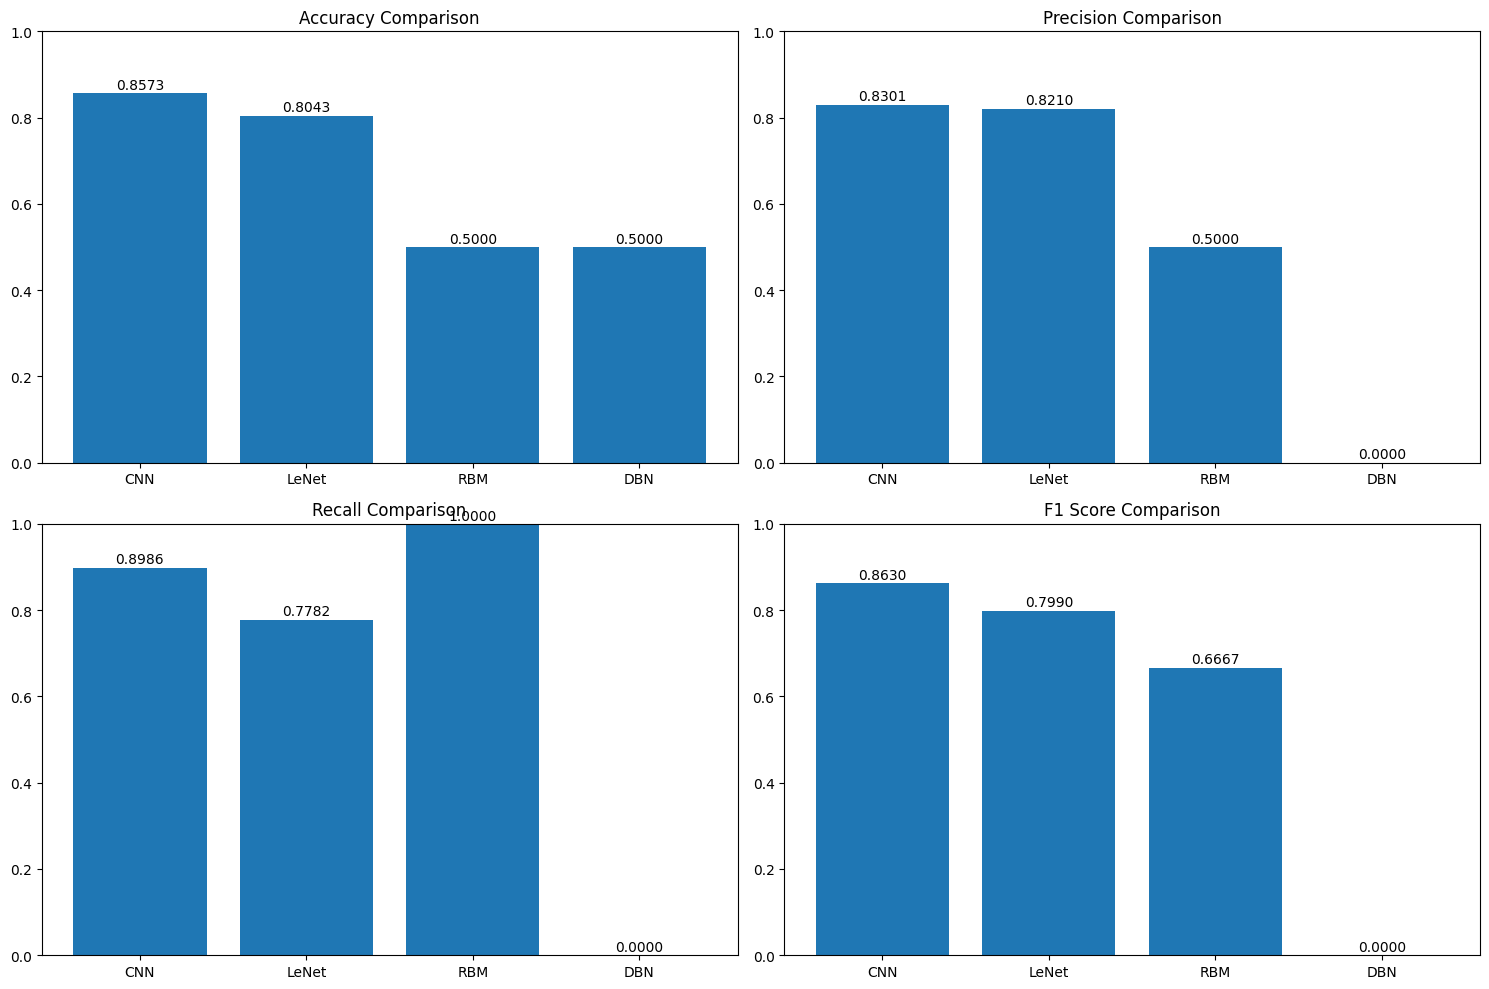

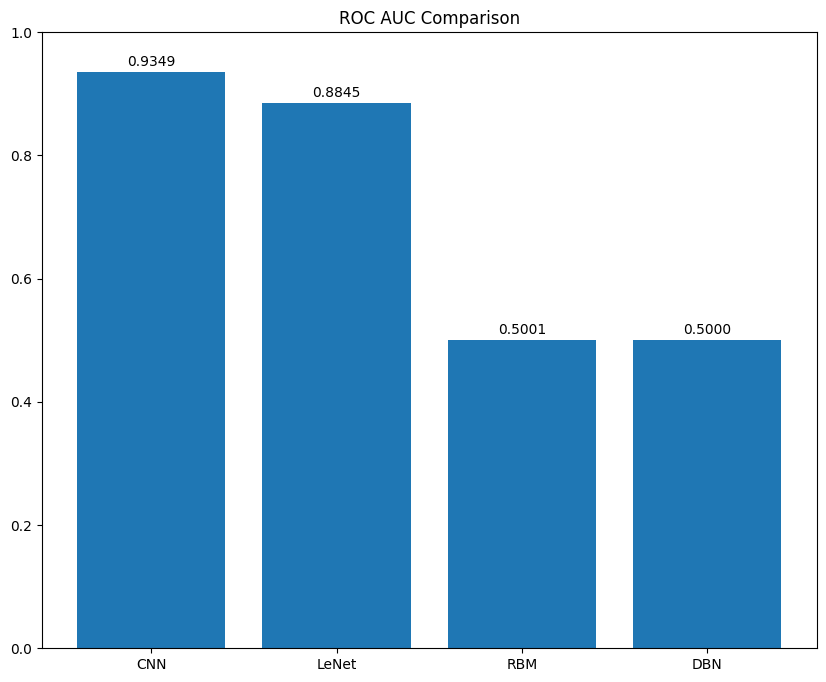


Best model based on F1 score: CNN
Accuracy: 0.8573
Precision: 0.8301
Recall: 0.8986
F1 Score: 0.8630
ROC AUC: 0.9349


In [ ]:
# Collect results from all models
results = [cnn_results, lenet_results, rbm_results, dbn_results]
model_names = [result['model_name'] for result in results]
accuracy = [result['accuracy'] for result in results]
precision = [result['precision'] for result in results]
recall = [result['recall'] for result in results]
f1 = [result['f1'] for result in results]
roc_auc = [result['roc_auc'] for result in results]

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
})

print("Model Performance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.bar(model_names, accuracy)
plt.title('Accuracy Comparison')
plt.ylim([0, 1])
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Plot precision
plt.subplot(2, 2, 2)
plt.bar(model_names, precision)
plt.title('Precision Comparison')
plt.ylim([0, 1])
for i, v in enumerate(precision):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Plot recall
plt.subplot(2, 2, 3)
plt.bar(model_names, recall)
plt.title('Recall Comparison')
plt.ylim([0, 1])
for i, v in enumerate(recall):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Plot F1 score
plt.subplot(2, 2, 4)
plt.bar(model_names, f1)
plt.title('F1 Score Comparison')
plt.ylim([0, 1])
for i, v in enumerate(f1):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Plot ROC AUC for all models
plt.figure(figsize=(10, 8))
plt.bar(model_names, roc_auc)
plt.title('ROC AUC Comparison')
plt.ylim([0, 1])
for i, v in enumerate(roc_auc):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

# Determine best model
best_model_index = np.argmax(f1)  # Using F1 score to determine best model
best_model = model_names[best_model_index]

print(f"\nBest model based on F1 score: {best_model}")
print(f"Accuracy: {accuracy[best_model_index]:.4f}")
print(f"Precision: {precision[best_model_index]:.4f}")
print(f"Recall: {recall[best_model_index]:.4f}")
print(f"F1 Score: {f1[best_model_index]:.4f}")
print(f"ROC AUC: {roc_auc[best_model_index]:.4f}")

In [ ]:
# Function to predict sentiment of a new review
def predict_sentiment(model, review_text, word_index, max_length=200):
    # Clean and tokenize
    cleaned_text = clean_text(review_text)
    tokens = tokenize_and_remove_stopwords(cleaned_text)

    # Convert to sequence
    sequence = [word_index.get(word, word_index['<UNK>']) for word in tokens]

    # Pad sequence
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence = sequence + [0] * (max_length - len(sequence))

    # Convert to tensor
    input_tensor = torch.tensor([sequence], dtype=torch.long).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
        probability = prediction.item()
        sentiment = "Positive" if probability > 0.5 else "Negative"

    return sentiment, probability

# Test with positive reviews
positive_review1 = "This film was absolutely brilliant! The director's vision was perfectly executed with stunning cinematography and a moving soundtrack."
positive_review2 = "What a masterpiece! This is definitely going on my list of all-time favorites. The acting performances were Oscar-worthy."

# Test with negative reviews
negative_review1 = "I wasted two hours of my life on this terrible movie. The plot had so many holes it was like watching Swiss cheese on screen."
negative_review2 = "The acting was wooden, the dialogue was cringe-worthy, and the special effects looked like they were made on a home computer."

# Test all reviews
reviews = [
    ("Positive Example 1", positive_review1),
    ("Positive Example 2", positive_review2),
    ("Negative Example 1", negative_review1),
    ("Negative Example 2", negative_review2)
]

print("Testing custom reviews with CNN model:\n")
for name, review in reviews:
    sentiment, probability = predict_sentiment(cnn_model, review, word_index)
    print(f"Review ({name}): {review[:100]}...")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Confidence: {probability:.4f}")
    print("-" * 80)


Testing custom reviews with CNN model:

Review (Positive Example 1): This film was absolutely brilliant! The director's vision was perfectly executed with stunning cinem...
Predicted sentiment: Positive
Confidence: 0.9967
--------------------------------------------------------------------------------
Review (Positive Example 2): What a masterpiece! This is definitely going on my list of all-time favorites. The acting performanc...
Predicted sentiment: Positive
Confidence: 0.9949
--------------------------------------------------------------------------------
Review (Negative Example 1): I wasted two hours of my life on this terrible movie. The plot had so many holes it was like watchin...
Predicted sentiment: Negative
Confidence: 0.0071
--------------------------------------------------------------------------------
Review (Negative Example 2): The acting was wooden, the dialogue was cringe-worthy, and the special effects looked like they were...
Predicted sentiment: Negative
Confiden